In [3]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

try:
    from private.lyap import corr_dim
except:
    from nolds import corr_dim


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Add a single dynamical system to the database

In [ ]:


def compute_period()


In [ ]:

Total models being analyzed is 131.
HyperBao
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.0003274730090135916 0.4366306786847887
HyperCai
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.0003855974037081736 0.5739124148214677

In [ ]:
# We will make a local copy of the internal database
OUTPUT_FILE = "./chaotic_attractors2.json"
INPUT_FILE = "dysts/data/chaotic_attractors.json"
# INPUT_FILE = "./dysts/data/chaotic_attractors.json"
# INPUT_FILE = OUTPUT_FILE

with open(INPUT_FILE, "r") as file:
    data = json.load(file)
print(f"Total models being analyzed is {len(data.keys())}.")


for i, name in enumerate(get_attractor_list()):
#     if "dt" in data[name]:
#         continue
    
    if "Hyper" not in name:
        continue
        
    model = getattr(dysts.flows, name)()
    print(name)
    
    dt, period = compute_timestep(model, return_period=True)
    print(dt, period)

    data[name]["dt"] = dt
    data[name]["period"] = period
    # Save new file
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(data, f, indent=4)    

Total models being analyzed is 131.
HyperBao


In [4]:
def find_period(model):
    pass

118

Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20


0.00021485770147222755

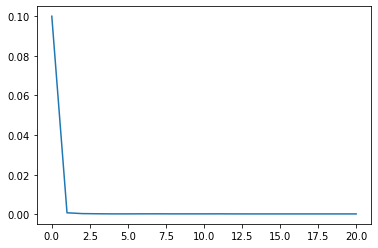

In [58]:
# find integration timescale

# Find integration timestep 




eq = Lorenz()
eq.dt = 0.1
compute_timestep(eq)

In [57]:
np.percentile([0.4, -.9, 0.4, 0.2, 1, 1, 1,1, 1, 1,1, 1, 1,1, 1, 1,1, 1, 1,1, 1, 1, 1, 10], 95)

1.0

4.535666666666667


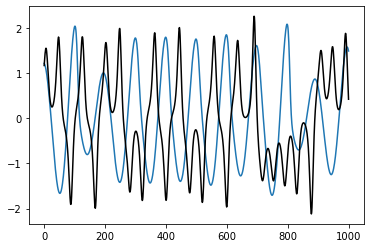

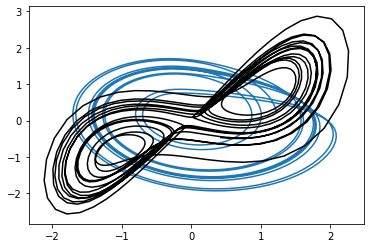

In [42]:
# Plot a reference trajectory as a sanity check
eq = Rossler()
sol0 = eq.make_trajectory(5000, resample=True, standardize=True)

# Plot new system trajectory. For single-modal attractors, there should be ~10 dominant peaks in interval
eq = LorenzStenflo()
eq.dt *= 10
# eq.r *= 0.8
# eq.ic = np.array([-0.08541919, -0.05204435,  1.34515262])
# eq.dt /= 10
eq.period /= 10 * (3/10)
# eq.period /= 2
# eq.period /= 20/10 * 8.5/10
# eq.dt = 0.01
# eq.period *= 5


sol = eq.make_trajectory(5000, resample=True, standardize=True, postprocess=True, pts_per_period=100)
# eq.ic = np.vstack([eq.ic, eq.ic])

plt.figure()
plt.plot(sol0[:1000, 0])
plt.plot(sol[:1000, 0], 'k')

plt.figure()
plt.plot(sol0[:1000, 0], sol0[:1000, 1])
plt.plot(sol[:1000, 0], sol[:1000, 1], 'k')

print(eq.period)

# Find dynamical properties of each system

In [15]:
# We will make a local copy of the internal database
OUTPUT_FILE = "./chaotic_attractors2.json"
INPUT_FILE = "dysts/data/chaotic_attractors.json"
# INPUT_FILE = "./dysts/data/chaotic_attractors.json"
INPUT_FILE = OUTPUT_FILE
RECALCULATE = True

points_to_sample = 10 # number of initial conditions to sample when computing values

with open(INPUT_FILE, "r") as file:
    data = json.load(file)
print(f"Total models being analyzed is {len(data.keys())}.")


for i, item in enumerate(get_attractor_list()):

    
    
    model = getattr(dysts.flows, item)()

    
#     if not hasattr(model, "_postprocessing"):
#         continue
        
#     if item in ["ArnoldBeltramiChildress", "ArnoldWeb", "BickleyJet", "BlinkingVortex", "BlinkingRotlet", "CircadianRhythm",
#                 "ForcedBrusselator", "DoubleGyre", "DoublePendulum", "Duffing", "FluidTrampoline", "ForcedBrusselator", "ForcedVanDerPol",
#                "ForcedFitzHughNagumo", "OscillatingFlow", "StickSlipOscillator", "TurchinHanski"]:
#         continue

    if hasattr(model, "_postprocessing"):
        continue
    if item in ["ArnoldBeltramiChildress", "ArnoldWeb", "BickleyJet", "BlinkingVortex", "BlinkingRotlet", "CircadianRhythm", "ForcedFitzHughNagumo",
            "ForcedBrusselator", "DoubleGyre", "DoublePendulum", "Duffing", "FluidTrampoline", "ForcedBrusselator", "ForcedVanDerPol", "PiecewiseCircuit",
           "ForcedFitzHughNagumo", "OscillatingFlow", "StickSlipOscillator", "TurchinHanski", "SprottMore", "SwingingAtwood", "NuclearQuadrupole"]:
        continue
    
    print(str(i), item, ": ", end="")
    current_fields = list(data.keys())
    
#     check_set = {"maximum_lyapunov_estimated", "lyapunov_spectrum", "correlation_dimension"}
#     if check_set.intersection(set(current_keys)) == check_set and not RECALCULATE:
#         print("All fields already filled; skipping calculation.")
#         continue
    
    model.dt /= 10
    sample_pts = sample_initial_conditions(model, points_to_sample)
    #print("Finished selecting initial points on attractor.")
    pts_per_trajectory = 15000 # number of timesteps to use to find the jacobian
    
#     try:

    all_estimates_lyap = list()
    all_estimates_corrdim = list()
    all_estimates_kydim = list()
    for j, sample_pt in enumerate(sample_pts):
        print(".", end="")
        model = getattr(dysts.flows, item)()
#         model.dt /= 10
        model.ic = sample_pt
        
        lyapval = find_lyapunov_exponents(model, pts_per_trajectory, pts_per_period=500)
        all_estimates_lyap.append(lyapval)

        sol = model.make_trajectory(10000, resample=True, pts_per_period=100)
        try:
            all_estimates_corrdim.append(corr_dim(sol))
            all_estimates_kydim.append(kaplan_yorke_dimension(lyapval))
        except:
            print("Bad starting point; ignoring this")
            pass

    lyap = np.median(np.array(all_estimates_lyap), axis=0)
    cdim = np.median(all_estimates_corrdim)
    kydim = np.median(all_estimates_kydim)

    # lyap_minmag = np.min(np,abs(lyap))
    # dissipation = np.sum(lyap)

    # if dissipation > 0.0:
    # if lyap_minmag < 1e-3: 

    if "maximum_lyapunov_estimated" not in data[item] or RECALCULATE:
        data[item]["maximum_lyapunov_estimated"] = np.max(lyap)
        print(f"lyap: {np.max(lyap)} ", end="")

    if "lyapunov_spectrum_estimated" not in data[item] or RECALCULATE:
        data[item]["lyapunov_spectrum_estimated"] = list(lyap)
        print(f"spectrum: {lyap} ", end="")

    if "kaplan_yorke_dimension" not in data[item] or RECALCULATE:
        data[item]["kaplan_yorke_dimension"] = kydim
        print(f"kydim: {kydim} ", end="")

    if "correlation_dimension" not in data[item] or RECALCULATE:
        data[item]["correlation_dimension"] = cdim
        print(f"corr_dim: {cdim} ", end="")

#     if "permutation_entropy" not in data[item] or RECALCULATE:
    print("\n")




    # Save new file
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(data, f, indent=4)

#     except:
#         print(f"Skipped {item}")
#         continue

print("Completed.")



Total models being analyzed is 118.
34 ForcedFitzHughNagumo : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Expect slowdown due to excessive integration required; scale factor 5952.452202826269
  if upscale_factor > 1e3: warnings.warn(f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Bad starting point; ignoring this
.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Bad starting point; ignoring this
.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Bad starting point; ignoring this
.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Bad starting point; ignoring this
.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


Bad starting point; ignoring this
.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:162: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


lyap: 1.2881170129500874e-05 spectrum: [ 1.28811701e-05 -3.32256454e-03 -9.26416704e-01] kydim: 1.5705852319395741 corr_dim: 1.6108397295434371 

Completed.


[array([-0.00689335, -0.04419094, -1.02485524]),
 array([-0.00432312, -0.04410006, -1.02793897]),
 array([-0.00389206, -0.04347165, -1.0278245 ]),
 array([-0.00413197, -0.04384894, -1.02794013]),
 array([-0.00641267, -0.04388455, -1.02649245])]

In [29]:
all_estimates_kydim

[]

In [28]:
all_estimates_lyap
# all_estimates_corrdim
# all_estimates_kydim

[array([-0.00578363, -0.04364873, -1.07048338]),
 array([-0.00263803, -0.04353077, -1.06783466]),
 array([-0.00811805, -0.04374871, -1.06625182]),
 array([-0.00612826, -0.04399496, -1.06983142]),
 array([-0.00592742, -0.04336548, -1.07133956]),
 array([-0.00795304, -0.04373689, -1.07096196]),
 array([-0.00169322, -0.04374903, -1.06830632]),
 array([-0.00625455, -0.04326567, -1.06983313]),
 array([-0.00638326, -0.04322452, -1.07042602]),
 array([-0.0061506 , -0.04322437, -1.06860455])]

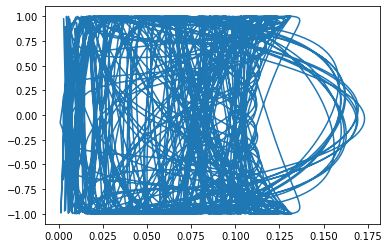

In [7]:
plt.plot(sol[:, 0], sol[:, 1])

In [ ]:
# fix these ones
PiecewiseCircuit, Torus (KY dim)

In [37]:
# all_estimates_lyap2 = all_estimates_lyap
# all_estimates_corrdim2 = all_estimates_corrdim

# all_estimates_lyap3 = all_estimates_lyap
# all_estimates_corrdim3 = all_estimates_corrdim



In [42]:
all_estimates_lyap = all_estimates_lyap2 + all_estimates_lyap3
all_estimates_corrdim = all_estimates_corrdim2 + all_estimates_corrdim3 

lyap = np.median(np.array(all_estimates_lyap), axis=0)
cdim = np.median(all_estimates_corrdim)

# lyap_minmag = np.min(np,abs(lyap))
# dissipation = np.sum(lyap)

# if dissipation > 0.0:
# if lyap_minmag < 1e-3: 

# if "maximum_lyapunov_estimated" not in data[item] or RECALCULATE:
#     data[item]["maximum_lyapunov_estimated"] = np.max(lyap)
#     print(f"lyap: {np.max(lyap)} ", end="")

# if "lyapunov_spectrum_estimated" not in data[item] or RECALCULATE:
#     data[item]["lyapunov_spectrum_estimated"] = list(lyap)
#     print(f"spectrum: {lyap} ", end="")

# if "kaplan_yorke_dimension" not in data[item] or RECALCULATE:
#     kydim = kaplan_yorke_dimension(lyap)
#     data[item]["kaplan_yorke_dimension"] = kydim
#     print(f"kydim: {kydim} ", end="")

# if "correlation_dimension" not in data[item] or RECALCULATE:
#     data[item]["correlation_dimension"] = cdim
#     print(f"corr_dim: {cdim} ", end="")

# #     if "permutation_entropy" not in data[item] or RECALCULATE:
# print("\n")

# Save new file
with open(OUTPUT_FILE, 'w') as f:
    json.dump(data, f, indent=4)

In [39]:
all_estimates_lyap

[array([ 10.10499267,   0.        , -14.08287363]),
 array([ 6.36587039,  0.        , -3.75567834]),
 array([  9.27344449,   0.        , -12.01192819]),
 array([ 7.56021632,  0.        , -6.85624389]),
 array([ 7.81555317,  0.        , -4.07225543]),
 array([ 7.40224482,  0.        , -3.45851071]),
 array([ 25.97088128,   0.        , -54.4838455 ]),
 array([ 6.65324513,  0.        , -4.98665801]),
 array([ 20.133225  ,   0.        , -40.09692672]),
 array([ 8.16222722,  0.        , -6.65900699]),
 array([ 7.15660455,  0.        , -7.22347337]),
 array([  8.88328642,   0.        , -10.79868387]),
 array([ 7.1987912 ,  0.        , -6.45060063])]

In [ ]:
lyap = np.median(np.array(all_estimates_lyap), axis=0)
cdim = np.median(all_estimates_corrdim)

In [5]:
if hasattr(model, "_postprocessing"):
    
    ynxt = y0 + model.dt * model.rhs(yval, tval)
    
    grad = (y_nxt - y0)
    
    
    ynxt = y0 + model.dt * model.rhs(yval, tval)
    
    z = h(y)
    z' = dh/dy * y'

9

'HenonHeiles'

In [6]:
sol = Lorenz().make_trajectory(4968, pts_per_period=100, resample=True)
print(sol.shape)

sol = MackeyGlass().make_trajectory(5000, pts_per_period=500, resample=True)
print(sol.shape)


(4968, 3)
(4698, 3)


In [ ]:
TRAIN = 
TEST = 



# Make a collection of standard multivariate series
DATA_PATH = "./data/multivariate_dynamics.json.gz"

# Make a collection of univariate series for single-step prediction
DATA_PATH = "./data/univariate_dynamics.json.gz"

# Repeat both above for different levels of granularity per period (pts_per_period=10, pts_per_period=100)

In [ ]:
# Make attribute files for the specific instantiations included here

#


In [ ]:
# blinking vortex: need to add the timelike variable to the dynamical equation

In [ ]:
# 0.9058,  0.0000, -14.572 for these parameters